## same as first but now for Af + Cf

- model is trained of CF and AF attractiveness scores

In [1]:
from PIL import Image
import hdbscan
import time
import seaborn as sns
import pickle
import numpy as np
import pandas as pd
from umap import UMAP
from image_helpers import *
from tsne import image_scatter_plot
from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_context("poster")
%pylab inline

import warnings
warnings.filterwarnings('ignore')
pylab.rcParams['figure.figsize'] = (15, 15)

Populating the interactive namespace from numpy and matplotlib


In [2]:
data, paths, encodings, arrays_rescaled, X = load_encodings('../data/AF_ALL_faces_encodings.pickle')
paths, encodings, arrays_rescaled, X = append_new_dataset(paths, encodings, arrays_rescaled, X, '../data/CF_ALL_faces_encodings.pickle')

2361 2361 2361 2361


In [3]:
_, paths_tinder, encodings_tinder, arrays_rescaled_tinder, X_tinder = load_encodings('../data/tinder_pics_likes_faces_deduped_firsts_encodings.pickle')
paths_tinder, encodings_tinder, arrays_rescaled_tinder, X_tinder = append_new_dataset(paths_tinder, encodings_tinder, arrays_rescaled_tinder, X_tinder, '../data/tinder_pics_2017_deduped_firsts_faces_encodings.pickle')
paths_tinder, encodings_tinder, arrays_rescaled_tinder, X_tinder = append_new_dataset(paths_tinder, encodings_tinder, arrays_rescaled_tinder, X_tinder, '../data/tinder_pics_dislikes_faces_firsts_deduped_encodings.pickle')


356 356 356 356
994 994 994 994


In [4]:
from sklearn.linear_model import LogisticRegression, LinearRegression

In [5]:
df_ratings = pd.read_csv('../data/SCUT-FBP5500_v2/train_test_files/All_labels.txt', sep=' ', header=None)
df_ratings.columns = ['file_name', 'mean_rating']

In [6]:
look_up_file_to_attractiveness_rating = dict(zip(df_ratings['file_name'], df_ratings['mean_rating']))
paths = [file_path.replace('_face', '').split('/')[-1] for file_path in paths]
colors_dic = [look_up_file_to_attractiveness_rating.get(just_file_name) for just_file_name in paths]
pd.Series(colors_dic).value_counts()

df_file_ratings=pd.DataFrame()
df_file_ratings['ratings']=colors_dic 
df_file_ratings['file_names']=paths 


In [7]:
CF_AF_ALL_labels = df_file_ratings['ratings']

In [8]:
def get_rsquared(y, x):
    '''
    Get RMSE given response variable (y) and predictor set (X)
    USE CASE: helper function for VIF
    '''
    import statsmodels.api as sm

    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
 
    return model.rsquared

get_rsquared(CF_AF_ALL_labels, encodings)

0.7547234549697002

In [8]:
def model_cv_score(model, feat_matrix, labels, folds=10, scoring='r2'):
    from sklearn import cross_validation
    '''
    I: persisted model object, feature matrix (numpy or pandas datafram), labels, k-folds, scoring metric
    O: mean of scores over each k-fold (float)
    '''
    return cross_validation.cross_val_score(model, feat_matrix, labels, cv=folds, scoring=scoring)

model_cv_score(LinearRegression(), encodings, CF_AF_ALL_labels)


array([0.68880709, 0.74613271, 0.7159897 , 0.72132693, 0.74930299,
       0.76462475, 0.76341708, 0.67886772, 0.66728786, 0.63851801])

In [11]:
from sklearn.ensemble import RandomForestRegressor

model_cv_score(RandomForestRegressor(n_estimators=500, n_jobs=-1), encodings, CF_AF_ALL_labels)

array([0.63546137, 0.6424161 , 0.66062813, 0.65196012, 0.66376731,
       0.68720658, 0.65194175, 0.50340469, 0.52829778, 0.5316076 ])

In [10]:
lr = LinearRegression().fit(encodings, CF_AF_ALL_labels)

In [11]:
preds_tinder = lr.predict(encodings_tinder)

In [12]:
num_of_dislikes = len(paths_tinder) - 356

In [13]:
tinder_labels = np.r_[np.ones(356), np.zeros(num_of_dislikes) ]

In [14]:
paths_tinder_ = [path.split('/')[-1].replace('_face.png','').replace('_face.jpg','') for path in paths_tinder]

In [16]:
df = pd.DataFrame (list(zip(paths_tinder_, preds_tinder, tinder_labels)))
df.columns = ['file_name', 'rating', 'like_or_not']
df

,file_name,rating,like_or_not
0,1527363788_Anoushka_0,3.672368,1.0
1,1527366134_Talisha_0,1.188311,1.0
2,1526522411_Bria_1,3.053166,1.0
3,1527365707_Rose_0,4.267026,1.0
4,1525746651_Athena_1,3.427540,1.0
5,1526004657_Samanta_0,3.112533,1.0
6,1527365210_Ayse_0,2.496699,1.0
7,1525746599_Alex_1,3.252296,1.0
8,1526593996_Angelica_0,3.861071,1.0
9,1526837215_Keanu_0,3.511809,1.0


In [18]:
df[df.rating > 4.3 ]

,file_name,rating,like_or_not
15,1527365912_Kristin_0,4.326441,1.0
55,1526093265_Stephanie_0,4.616597,1.0
71,1526593707_Camilla_0,4.401614,1.0
75,1526265289_Alexa_0,4.427050,1.0
92,1526093389_Brianna_1,4.397148,1.0
129,1490837468_Katie_5,4.336972,1.0
268,1490753769_Katarina_1,4.458436,1.0
346,1489201378_Bára_1,4.547401,1.0
655,1526346764_Elena_0,4.430002,0.0
664,1527365913_Özlem_0,4.559840,0.0


In [20]:
df[(df.rating > 4.0)  & (df.like_or_not == 0.0)]

,file_name,rating,like_or_not
488,1526346830_Geetanjali_3,4.227967,0.0
513,1526004699_Bianca_0,4.262142,0.0
584,1526003841_Hannah_0,4.247589,0.0
611,1526522178_Dahlia_0,4.067454,0.0
655,1526346764_Elena_0,4.430002,0.0
664,1527365913_Özlem_0,4.559840,0.0
688,1527365915_Nuha_0,4.096166,0.0
730,1527364104_Lauren_0,4.036446,0.0
742,1527364262_Mairin_0,4.073948,0.0
766,1526346909_Lauren_2,4.062944,0.0


It clearly doesn't work well with africans. I'd have to made a classifier which would lead to a regressors for submodels to CF, AF, africans, etc.

In [21]:
df[(df.rating < 2.6)  & (df.like_or_not == 1.0)]

,file_name,rating,like_or_not
1,1527366134_Talisha_0,1.188311,1.0
6,1527365210_Ayse_0,2.496699,1.0
26,1526837526_Ruth_2,2.389932,1.0
29,1526004131_Geraldine_0,2.510569,1.0
144,1487385784_Ma_1,2.537733,1.0
156,1490751366_Sarah_1,2.549913,1.0
234,1487300741_Linette_0_negative,1.752928,1.0
289,1490404659_Laura_1,2.240450,1.0
312,1487212172_Diane_1,2.406931,1.0
319,1490753169_Kristin_1,2.395169,1.0


# interestingly it singled out all the Africans

In [18]:
df[df.like_or_not == 1.0].rating.median()

3.4634684152963233

count    994.000000
mean       3.216137
std        0.544572
min        0.980992
25%        2.898243
50%        3.249627
75%        3.591669
max        4.616597
Name: rating, dtype: float64
skew --  -0.5392037876727943
kurtosis -- 0.6421148761282249


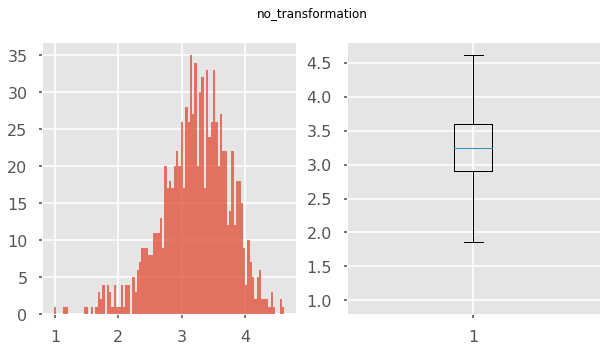

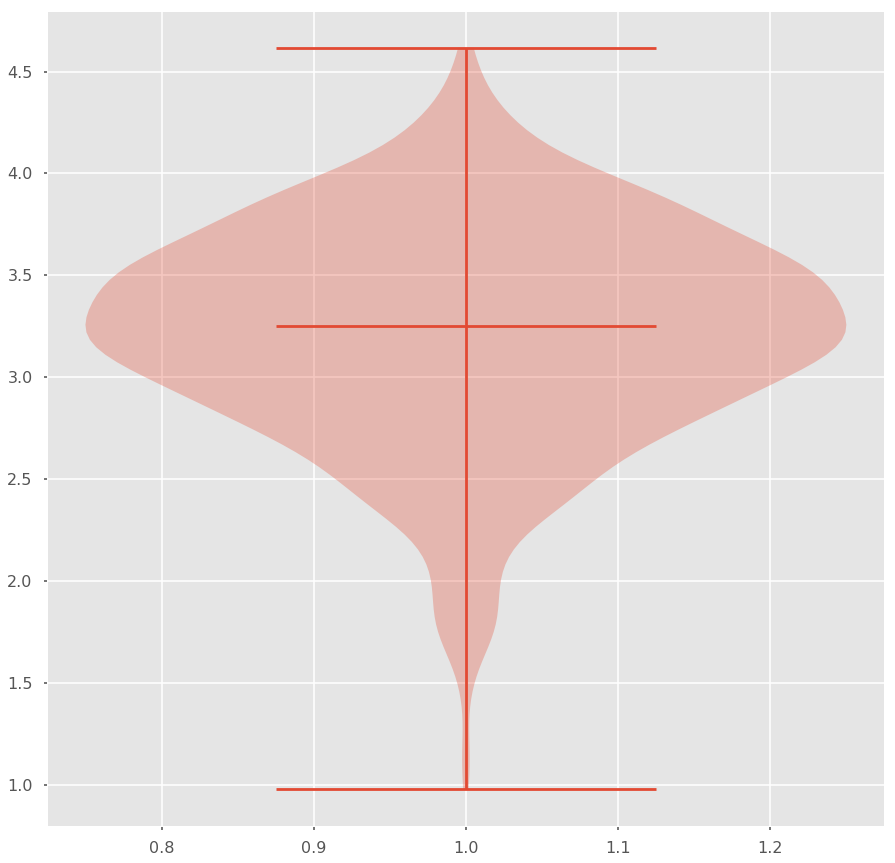

In [24]:
plot_distribution(df.rating)

count    356.000000
mean       3.445651
std        0.470474
min        1.188311
25%        3.120727
50%        3.463468
75%        3.798845
max        4.616597
Name: rating, dtype: float64
skew --  -0.39581326694603014
kurtosis -- 1.0285251933440138


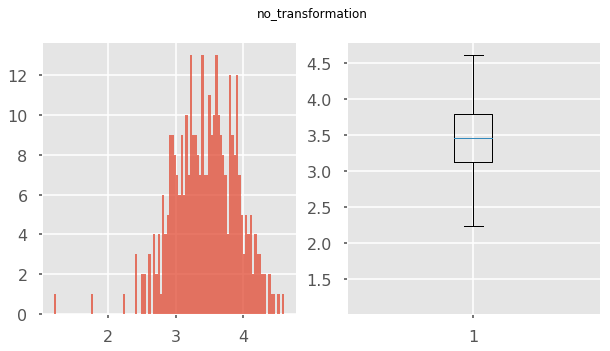

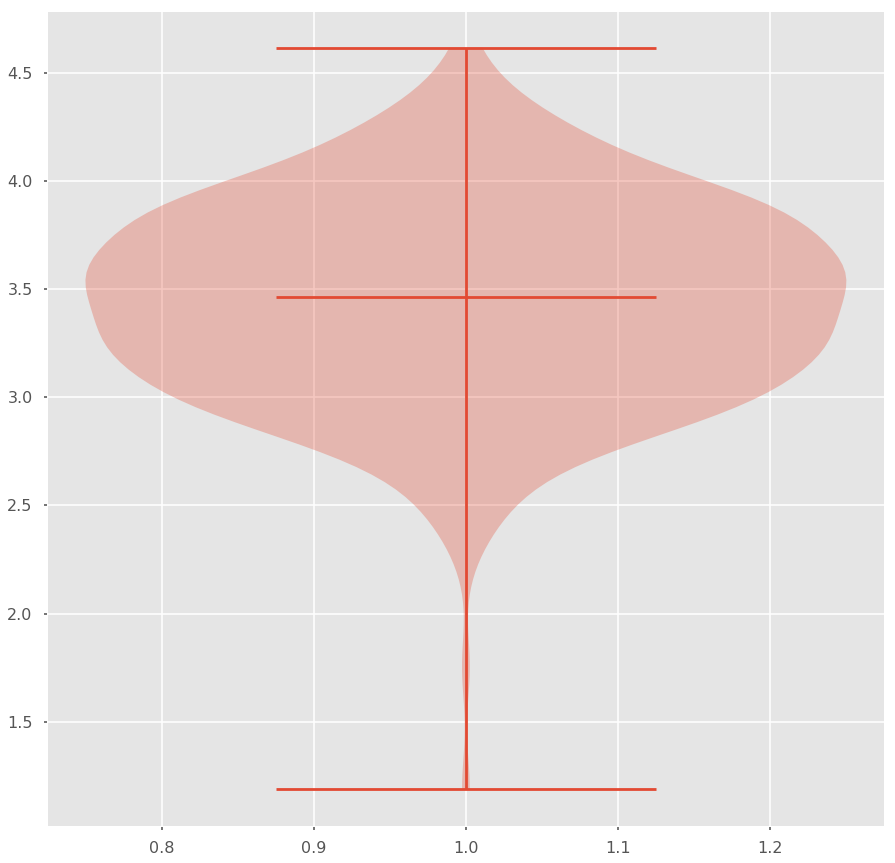

In [25]:
plot_distribution(df[df.like_or_not == 1.0].rating)

count    638.000000
mean       3.088070
std        0.541363
min        0.980992
25%        2.763025
50%        3.147014
75%        3.469906
max        4.559840
Name: rating, dtype: float64
skew --  -0.5659843703945696
kurtosis -- 0.43505633398436316


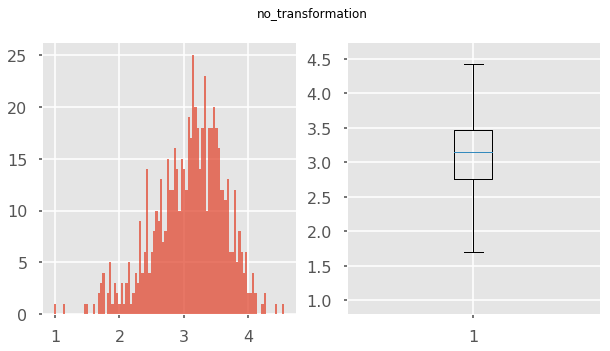

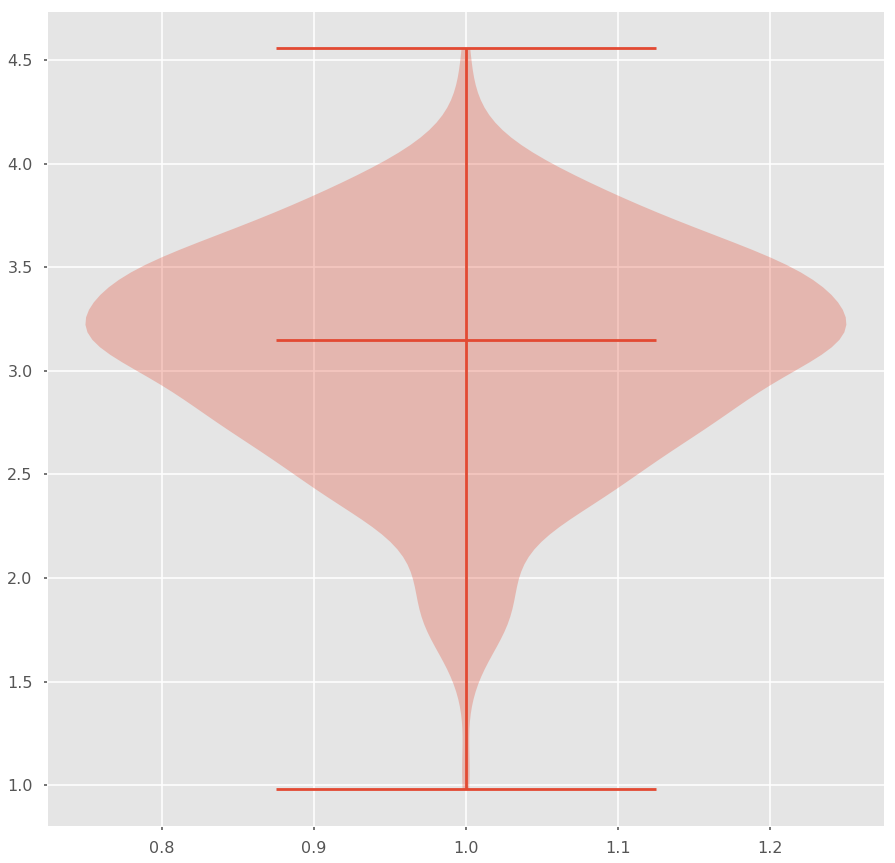

In [26]:
plot_distribution(df[df.like_or_not == 0.0].rating)

## Clearly two seperate populations

The likes: Notice how shifted to the right ( more attractive ) .

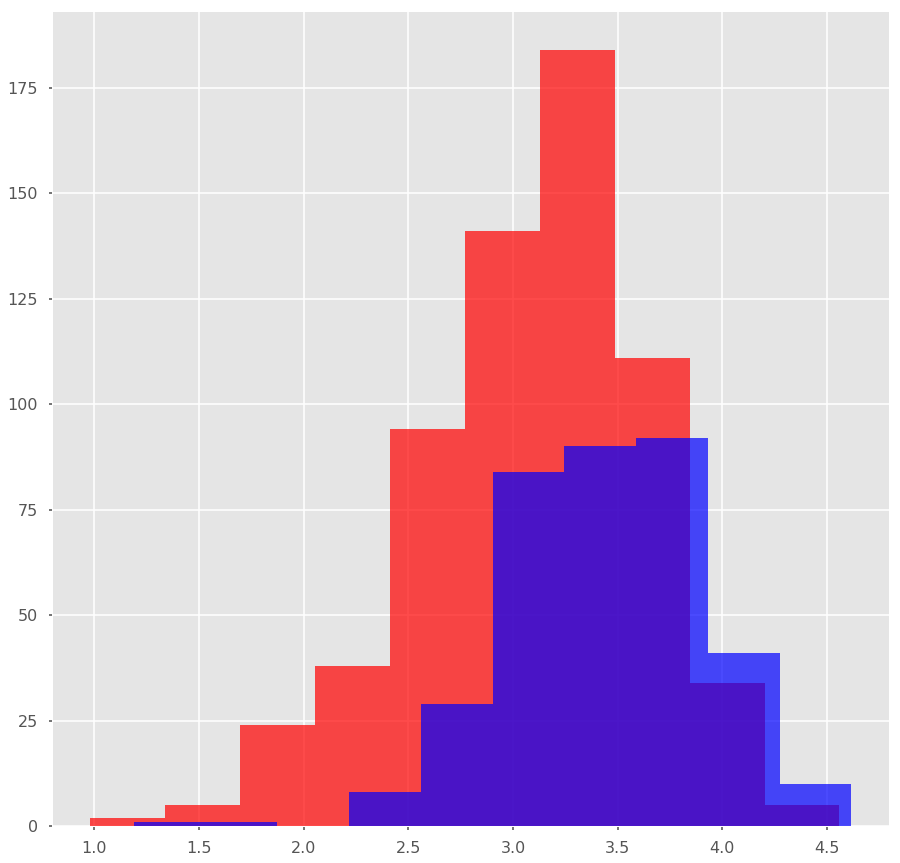

In [27]:
df[df.like_or_not == 0.0].rating.hist(alpha=0.7,bins=10, color='red')
df[df.like_or_not == 1.0].rating.hist(alpha=0.7,bins=10, color='blue')

{'bodies': [<matplotlib.collections.PolyCollection at 0x1a28ad1cf8>],
 'cbars': <matplotlib.collections.LineCollection at 0x1a28ad1048>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x1a28ad1fd0>,
 'cmedians': <matplotlib.collections.LineCollection at 0x1a28ac6128>,
 'cmins': <matplotlib.collections.LineCollection at 0x1a28ad1a20>}

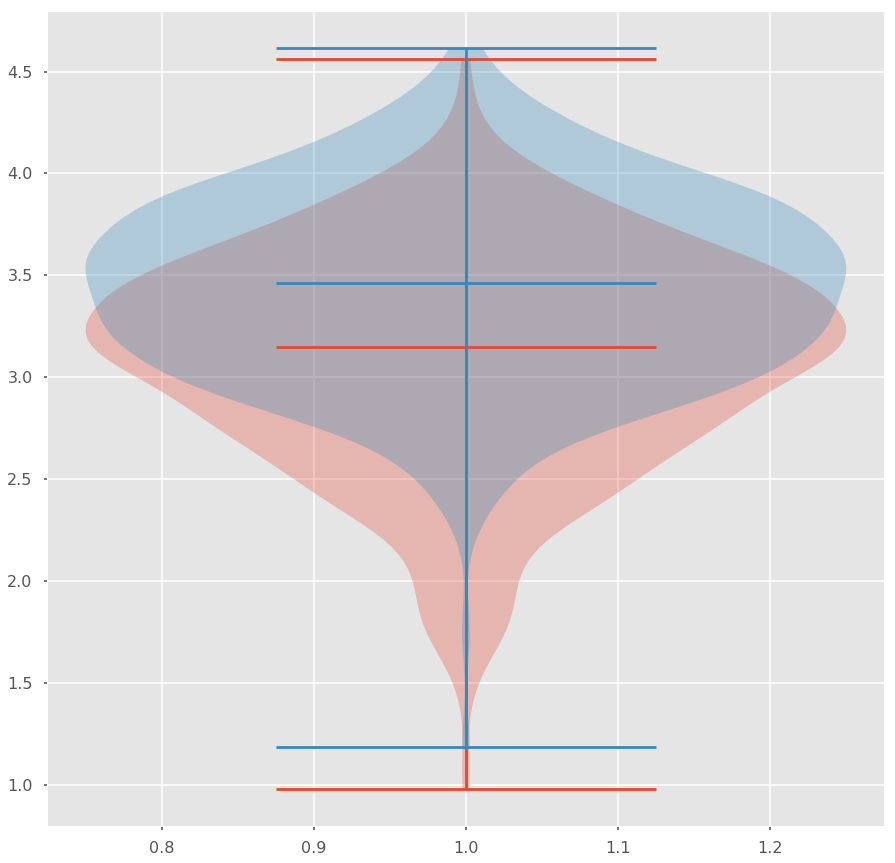

In [28]:
plt.violinplot(
       df[df.like_or_not == 0.0].rating,
       showmeans=False,
       showmedians=True
    )

plt.violinplot(
       df[df.like_or_not == 1.0].rating,
       showmeans=False,
       showmedians=True
    )


Notice Hannah

In [20]:
df.loc[df.rating.sort_values().index]

,file_name,rating,like_or_not
889,1526003326_Samantha_2,0.980992,0.0
621,1526836885_Adesuwa_0,1.130296,0.0
1,1527366134_Talisha_0,1.188311,1.0
811,1526593709_Rachel_0,1.457285,0.0
720,1526093220_Rachel_0,1.517398,0.0
749,1526003623_Sake_0,1.592437,0.0
791,1526003963_Vanessa_2,1.665756,0.0
379,1527364726_Shinekwa_0,1.695636,0.0
556,1526005049_Muhsinah_0,1.697091,0.0
868,1526093269_Lauren_0,1.704713,0.0
